<b>Multiclass Classification</b>

Multiclass classifiers (also called multinomial classifiers) can distinguish between more than two classes.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gc

from sklearn.linear_model import SGDClassifier as SGDC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report,confusion_matrix

Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are
capable of handling multiple classes directly. 

Others (such as Support Vector Machine
classifiers or Linear classifiers) are strictly binary classifiers. However, there are various
strategies that you can use to perform multiclass classification using multiple
binary classifiers.

For example, one way to create a system that can classify the digit images into 10
classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a
1-detector, a 2-detector, and so on). 

Then when you want to classify an image, you get
the decision score from each classifier for that image and you select the class whose
classifier outputs the highest score. This is called the one-versus-all (OvA) strategy
(also called one-versus-the-rest).

Another strategy is to train a binary classifier for every pair of digits: 

One to distinguish0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on.

This is called the one-versus-one (OvO) strategy.

If there are N classes, you need to
train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45
binary classifiers! When you want to classify an image, you have to run the image
through all 45 classifiers and see which class wins the most duels. 
The main advantage of OvO is that each classifier only needs to be trained on the part of the training
set for the two classes that it must distinguish.

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the
size of the training set, so for these algorithms OvO is preferred since it is faster to
train many classifiers on small training sets than training few classifiers on large
training sets. 

For most binary classification algorithms, however, OvA is preferred.
Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass
classification task, and it automatically runs OvA (except for SVM classifiers for
which it uses OvO).

<b>When you call fit over a multi class label ,under the hood Scikit-Learn actually trains 10 binary classifiers, gets their decision scores /prob for the image, and selected the class with the highest score/prob.

If you want to force ScikitLearn to use one-versus-one or one-versus-all, you can use
the OneVsOneClassifier or OneVsRestClassifier classes. Simply create an instance
and pass a binary classifier to its constructor. For example, this code creates a multiclass
classifier using the OvO strategy, based on a SGDClassifier:

In [13]:
MNIST=pd.read_csv(r"D://Datasets/MNIST/mnist_train.csv")

In [14]:
y=MNIST['label'].to_numpy()

y = y.reshape(y.shape[0], )
y=pd.Series(y)


M=MNIST.copy()
M.drop('label',axis=1,inplace=True)
X=M.copy()
del M
gc.collect()

28

In [15]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,shuffle=True,random_state=21)

In [19]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDC(random_state=42))
ovo_clf.fit(X_train, y_train)
pred=ovo_clf.predict(X_test)
len(ovo_clf.estimators_)

45

In [29]:
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1173
           1       0.98      0.97      0.97      1382
           2       0.91      0.90      0.91      1214
           3       0.91      0.87      0.89      1298
           4       0.93      0.93      0.93      1172
           5       0.83      0.88      0.85      1017
           6       0.95      0.95      0.95      1228
           7       0.95      0.90      0.92      1315
           8       0.85      0.90      0.87      1069
           9       0.86      0.88      0.87      1132

    accuracy                           0.92     12000
   macro avg       0.91      0.91      0.91     12000
weighted avg       0.92      0.92      0.92     12000



<b>Error Analysis

In [36]:
sgd_clf = SGDC(random_state=21)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=21)

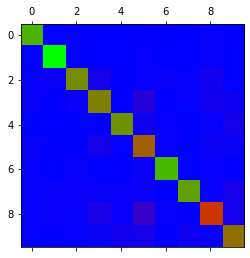

In [46]:
y_train_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=3)
conf_mx = confusion_matrix(y_test, y_train_pred)

plt.matshow(conf_mx, cmap=plt.cm.brg)
plt.show()

<b>Remember that rows
represent actual classes, while columns represent predicted classes

This confusion matrix looks fairly good, since most images are on the main diagonal,
which means that they were classified correctly.

Let’s focus the plot on the errors. First, you need to divide each value in the confusion
matrix by the number of images in the corresponding class, so you can compare error
rates instead of absolute number of errors (which would make abundant classes look
unfairly bad):

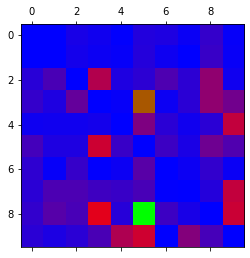

In [47]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.brg)
plt.show()

Notice that the errors are not perfectly symmetrical; for example, there are more 8s misclassified as 5s than the reverse.

Analyzing individual errors can also be a good way to gain insights on what your
classifier is doing and why it is failing, but it is more difficult and time-consuming

In [63]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

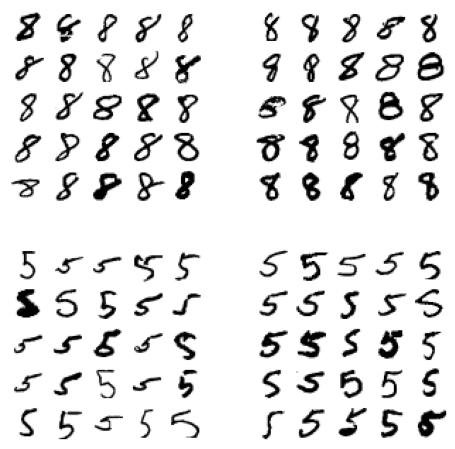

In [64]:
cl_a, cl_b = 8, 5
X_aa = X_test[(y_test == cl_a) & (y_train_pred == cl_a)].to_numpy()
X_ab = X_test[(y_test == cl_a) & (y_train_pred == cl_b)].to_numpy()
X_ba = X_test[(y_test == cl_b) & (y_train_pred == cl_a)].to_numpy()
X_bb = X_test[(y_test == cl_b) & (y_train_pred == cl_b)].to_numpy()

plt.figure(figsize=(8,8))

plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

The two 5×5 blocks on the left show digits classified as 8s, and the two 5×5 blocks on
the right show images classified as 5s. Some of the digits that the classifier gets wrong
(i.e., in the bottom-left and top-right blocks) are so badly written that even a human
would have trouble classifying them

However, most misclassified images seem like obvious errors to us,
and it’s hard to understand why the classifier made the mistakes it did.3 The reason is
that we used a simple SGDClassifier, which is a linear model. All it does is assign a
weight per class to each pixel, and when it sees a new image it just sums up the weighted
pixel intensities to get a score for each class. So since 8s and 5s differ only by a few
pixels, this model will easily confuse them.

<b>Multilabel Classification</b>

Until now each instance has always been assigned to just one class. In some cases you
may want your classifier to output multiple classes for each instance. For example,
consider a face-recognition classifier: what should it do if it recognizes several people
on the same picture? Of course it should attach one label per person it recognizes. Say
the classifier has been trained to recognize three faces, Alice, Bob, and Charlie; then
when it is shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning
“Alice yes, Bob no, Charlie yes”). Such a classification system that outputs multiple
binary labels is called a multilabel classification system.

<b>Multioutput Classification</b>

The last type of classification task we are going to discuss here is called multioutputmulticlass
classification (or simply multioutput classification). It is simply a generalization
of multilabel classification where each label can be multiclass (i.e., it can have
more than two possible values).